In [1]:
from my_functions import *

In [2]:
%load_ext autoreload
%autoreload 2

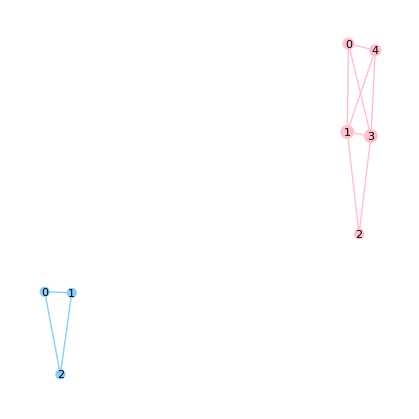

HeteroData(
  rmsd=0.0,
  protein={
    atoms=[5],
    x=[5, 8],
    pos=[5, 3]
  },
  ligand={
    atoms=[3],
    x=[3, 8],
    pos=[3, 3]
  },
  (protein, -, protein)={
    edge_index=[2, 8],
    edge_attr=[2]
  },
  (ligand, -, ligand)={
    edge_index=[2, 3],
    edge_attr=[2]
  },
  (protein, -, ligand)={
    edge_index=[2, 0],
    edge_attr=[2]
  }
)

In [21]:
data = generate_complex(5, 3, 8, 3, threshold=1.8, mu_std=2.5)
show_complex_networx(data, 'pos')
data

In [22]:
dataset = ProteinLigandComplexes()

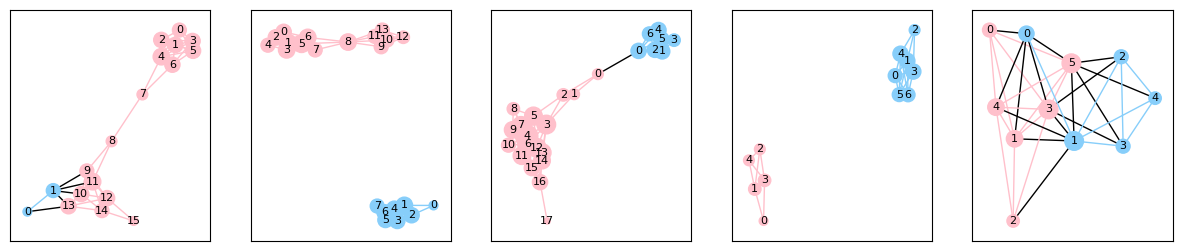

In [23]:
show_complex_batch_networx([dataset[i] for i in range(5)], 'pos')

In [6]:
# from transformer_m import TransformerM


A molecule $\mathcal{M}$ is made up of a collection of atoms held together by attractive forces. We denote $X \in \mathbb{R}^{n \times d}$ as the atoms with features, where $n$ is the number of atoms, and $d$ is the feature dimension. The structure of $\mathcal{M}$ can be represented in different formulations, such as 2D graph structure and 3D geometric structure. For the 2D graph structure, atoms are explicitly connected by chemical bonds, and we define $\mathcal{M}^{2D} = (X, E)$, where $e(i,j) \in E$ denotes the edge feature (i.e., the type of the bond) between atom $i$ and $j$ if the edge exists. For the 3D geometric structure, for each atom $i$, its position $r_i$ in the Cartesian coordinate system is provided. We define $\mathcal{M}^{3D} = (X, R)$, where $R = \{r_1 , ..., r_n \}$ and $r_i ∈ \mathbb{R}^3$. Our goal is to design a parametric model which can take either $\mathcal{M}^{2D}$ or $\mathcal{M}^{3D}$ (or both of them) as input, obtain contextual representations, and make predictions on downstream tasks.

**Encoding pair-wise relations in $E$.**
We use two terms to encode the structural relations between any atom pairs in the graph. First, we encode the shortest path distance (SPD) between two atoms to reflect their spatial relation. Let $\Phi_{ij}^{SPD}$ denote the SPD encoding between atom $i$ and $j$, which is a learnable scalar determined by the distance of the shortest path between $i$ and $j$. Second, we encode the edge features (e.g., the chemical bond types) along the shortest path between $i$ and $j$ to reflect the bond information. For most molecules, there exists only one distinct shortest path between any two atoms. Denote the edges in the shortest path from $i$ to $j$ as $SP_{ij} = (e_1, e_2, ..., e_N)$, and the edge encoding between $i$ and $j$ is defined as $$\Phi_{ij}^{Edge} = \frac{1}{N} \sum_{n=1}^N e_n(w_n)^T,$$ where $w_n$ are learnable vectors of the same dimension as the edge feature. Denote $\Phi^{SPD}$ and $\Phi^{Edge}$ as the matrix form of the SPD encoding and edge encoding, both of which are of shape $n \times n$.

In [7]:
# Check Encoding2D Layer for a given data
n = len(data['protein'].atoms)
n_heads = 1
num_spatial = 100

bond_encoder_2d = BondEncoding2D(num_heads=n_heads, num_spatial=num_spatial)
phi_spd, phi_edge = bond_encoder_2d(data['protein'].atoms, data['protein', '-', 'protein'].edge_index)

assert phi_spd.shape == torch.Size([n_heads, n, n])
assert phi_edge.shape == torch.Size([n_heads, n, n])

**Encoding pair-wise relations in $R$**. 
We encode the Euclidean distance to reflect the spatial relation between any pair of atoms in the 3D space. For each atom pair $(i,j)$, we first process their Euclidean distance with the Gaussian Basis Kernel function, 
$$
\psi^k_{(i, j)} =
-\frac{1}{\sqrt{2 \pi |\sigma^k|}}
\exp{-\frac{1}{2} \left( 
    \frac{\gamma_{(i, j)} \|r_i - r_j\| + \beta_{(i, j)} - \mu^k}
    {|\sigma^k|} 
\right)^2},
$$
$k = 1, ..., K$, where $K$ is the number of Gaussian Basis kernels. Then the 3D Distance encoding $\Phi_{ij}^{3D}$ Distance is obtained according to 
$$
\Phi_{ij}^{3D} = 
\text{GELU}(\psi_{(i,j)} W_D^1) W_D^2,
$$
where $\psi_{(i,j)} = [\psi_{(i,j)}^1, ..., \psi_{(i,j)}^K]^T, W_D^1 \in \mathbb{R}^{K \times K}, W_D^2 \in \mathbb{R}^{K \times 1}$ are learnable parameters. $\gamma_{(i,j)}, \beta_{(i,j)}$ are learnable scalars indexed by the pair of atom types, and $\mu^k, \sigma^k$ are learnable kernel center and learnable scaling factor of the $k$-th Gaussian Basis Kernel. Denote $\Phi_{ij}^{3D}$ Distance as the matrix form of the 3D distance encoding, whose shape is $n \times n$.

In [16]:
# Check Encoding3D Layer for a given data
n = len(data['protein'].atoms)
n_heads = 1
bond_encoder_3d = BondEncoding3D(n_heads=n_heads)
pos = data['protein'].pos
edge_types = torch.zeros(n, n).long()
atoms_from, atoms_to = data['protein', '-', 'protein'].edge_index
edge_types[atoms_from, atoms_to] = edge_types[atoms_to, atoms_from] = data['protein', '-', 'protein'].edge_attr[1]

phi_3d, psi_3d = bond_encoder_3d(pos, edge_types)
assert phi_3d.shape == torch.Size([n_heads, n, n])

**Integrating $\Phi^{SPD}$, $\Phi^{Edge}$ and $\Phi^{3D}$ in Transformer-M**. 
All pair-wise encodings defined above capture the interatomic information, which is in a similar spirit to the relative positional encoding for sequential tasks (Raffel et al., 2020). Therefore, we similarly locate those pair-wise signals in the self-attention module to provide complementary information to the dot-product term $XW_{Q}(XW_{K})^T$. For simplicity, we omit the index of attention head $h$ and layer $l$, and the modified attention matrix is defined as:
$$
A(X) = \text{softmax} \left(
    \frac{XW_{Q}(XW_{K})^T}{\sqrt{d}} + 
    \red{\underbrace{\Phi^{SPD} + \Phi^{Edge}}_{\text{2D pair-wise channel}}} + 
    \blue{\underbrace{\Phi^{3D}}_{\text{3D pair-wise channel}}}
\right)
$$

In [9]:
# Check MultiHeadAttention Layer for a given data
n = len(data['protein'].atoms)
n_heads = 1
num_spatial = 100
atom_feature_dim = 8

encoder2d = BondEncoding2D(num_heads=n_heads, num_spatial=num_spatial)
encoder3d = BondEncoding3D(n_heads=n_heads)
multihead_attention = MultiHeadAttention(atom_feature_dim=atom_feature_dim, num_heads=n_heads)

x = torch.randn(n, atom_feature_dim)
pos = data['protein'].pos
edge_types = torch.zeros(n, n).long()
atoms_from, atoms_to = data['protein', '-', 'protein'].edge_index
edge_types[atoms_from, atoms_to] = edge_types[atoms_to, atoms_from] = data['protein', '-', 'protein'].edge_attr[1]

phi_3d, psi_3d = encoder3d(pos, edge_types)
phi_spd, phi_edge = encoder2d(data['protein'].atoms, data['protein', '-', 'protein'].edge_index)

attn = multihead_attention(x, [0]*n, [0]*n, phi_3d, phi_spd, phi_edge, None)

assert attn.shape == torch.Size([n, 1])

**Encoding atom-wise structural information in $E$**. 
For atom $i$ the previous equation computes the normalized weights according to the semantic (first term) and spatial relation (last three terms) between $i$ and other atoms. However, the information is still not sufficient. For example, the importance (i.e., centrality) of each atom is missing in the attention. For each atom $i$, we use its degree as the centrality information. Formally, let $\Psi_{i}^{Degree}$ denote the degree encoding of the atom $i$, which is a $d$-dimensional learnable vector determined by the degree of the atom. Denote $\Psi^{Degree} = [\Psi_{1}^{Degree}, \Psi_{2}^{Degree}, \dots, \Psi_{n}^{Degree}]$ as the centrality encoding of all the atoms, which is of shape $n \times d$.

In [10]:
# Check AtomEncoding2D Layer for a given data
n = len(data['protein'].atoms)
n_heads = 1
num_spatial = 100
atom_feature_dim = 8

atom_encoder_2d = AtomEncoding2D(num_heads=n_heads, num_degree=5, atom_feature_dim=atom_feature_dim)

# x = torch.randn(n, atom_feature_dim)
edge_types = torch.zeros(n, n).long()
atoms_from, atoms_to = data['protein', '-', 'protein'].edge_index
edge_types[atoms_from, atoms_to] = edge_types[atoms_to, atoms_from] = data['protein', '-', 'protein'].edge_attr[1]
degrees = (edge_types != 0).sum(1)

phi_degree = atom_encoder_2d(data['protein'].atoms, degrees)

assert phi_degree.shape == torch.Size([n_heads, n, atom_feature_dim])

**Encoding atom-wise structural information in $R$**. 

Similar to the 2D atom-wise centrality encoding, for geometric data, we encode the centrality of each atom in the 3D space. For each atom $i$, we sum up the 3D Distance encodings between it and all other atoms. Let $\Psi_{i}^{\text{Sum of 3D Distance}}$ denote the centrality encoding of atom $i$, we have 
$$
\Psi_{i}^{\text{Sum of 3D Distance}} = \sum\limits_{j \in [n]} \psi_{(i, j)} W^3_D,
$$
where $W^3_D \in \mathbb{R}^{K \times d}$ is a learnable weight matrix. Similarly, we define $\Psi^{\text{Sum of 3D Distance}}$ as the encoding of all atoms, whose shape is $n \times d$.

In [11]:
# Check AtomEncoding2D Layer for a given data
n = len(data['protein'].atoms)
n_heads = 1
num_spatial = 100
atom_feature_dim = 8

atom_encoder_3d = AtomEncoding3D(num_heads=n_heads, n_kernels=128, atom_feature_dim=atom_feature_dim)
phi_3d_sum = atom_encoder_3d(psi_3d)

assert phi_3d_sum.shape == torch.Size([n_heads, n, atom_feature_dim])

**Integrating $\Psi^{Degree}$ and $\Psi^{\text{Sum of 3D Distance}}$ in Transformer-M**. 
We add the atom-wise encodings of 2D and 3D structures to the atom features in the input layer. Formally, the input $X(0)$ is modified as:
$$
X(0) = X + 
\red{\underbrace{\Psi^{Degree}}_{\text{2D atom-wise channel}}} + 
\blue{\underbrace{\Psi^{\text{Sum of 3D Distance}}}_{\text{3D atom-wise channel}}},
$$
Through this simple way, the structural information of molecules in both 2D and 3D formats is integrated into one Transformer model. It is easy to check that Transformer-M preserves equivariant properties for both data formats.

In [17]:
# Check MultiHeadAttention Layer for a given data
n = len(data['protein'].atoms)
n_heads = 1
num_spatial = 100
atom_feature_dim = 8

bond_encoder_2d = BondEncoding2D(num_heads=n_heads, num_spatial=num_spatial)
bond_encoder_3d = BondEncoding3D(n_heads=n_heads)
atom_encoder_2d = AtomEncoding2D(num_heads=n_heads, num_degree=5, atom_feature_dim=atom_feature_dim)
atom_encoder_3d = AtomEncoding3D(num_heads=n_heads, n_kernels=128, atom_feature_dim=atom_feature_dim)
multihead_attention = MultiHeadAttention(atom_feature_dim=atom_feature_dim, num_heads=n_heads)

x = torch.randn(n, atom_feature_dim)
pos = data['protein'].pos
edge_types = torch.zeros(n, n).long()
atoms_from, atoms_to = data['protein', '-', 'protein'].edge_index
edge_types[atoms_from, atoms_to] = edge_types[atoms_to, atoms_from] = data['protein', '-', 'protein'].edge_attr[1]
degrees = (edge_types != 0).sum(1)

phi_3d, psi_3d = bond_encoder_3d(pos, edge_types)
phi_spd, phi_edge = bond_encoder_2d(data['protein'].atoms, data['protein', '-', 'protein'].edge_index)
phi_degree = atom_encoder_2d(data['protein'].atoms, degrees)
phi_3d_sum = atom_encoder_3d(psi_3d)

attn = multihead_attention(x, phi_degree, phi_3d_sum, phi_3d, phi_spd, phi_edge, None)

assert attn.shape == torch.Size([n, 1])

**Transformer-M**

<img src="transformer_m.png" width="600">

In [18]:
import torch.nn as nn

In [19]:
class TransformerMEncoder(nn.Module):
    def __init__(self, n_heads, num_degree, atom_feature_dim, n_kernels, num_spatial):
        super().__init__()
        self.atom_encoder_2d = AtomEncoding2D(num_heads=n_heads, num_degree=num_degree, atom_feature_dim=atom_feature_dim)
        self.atom_encoder_3d = AtomEncoding3D(num_heads=n_heads, n_kernels=n_kernels, atom_feature_dim=atom_feature_dim)
        self.bond_encoder2d = BondEncoding2D(num_heads=n_heads, num_spatial=num_spatial)
        self.bond_encoder3d = BondEncoding3D(n_heads=n_heads)
        self.multihead_attention = MultiHeadAttention(atom_feature_dim=atom_feature_dim, num_heads=n_heads)

        # self.layers = nn.ModuleList([])
        # self.layers.extend([
        #     self.build_transformer_m_encoder_layer() 
        #     for _ in range(num_encoder_layers)
        # ])

    def forward(self, data_atoms, data_bonds):
        """
        data_atoms.x - atoms features
        data_atoms.pos - atoms positions
        data_atoms.atoms - atoms types
        data_bonds.edge_index - bonds: [atoms from, atoms_to]
        data_bonds.edge_attr - [bond length, bonds types]
        """
        n = len(data_atoms.atoms)
        edge_types = torch.zeros(n, n).long()
        atoms_from, atoms_to = data_bonds.edge_index
        edge_types[atoms_from, atoms_to] = edge_types[atoms_to, atoms_from] = data_bonds.edge_attr[1]
        degrees = (edge_types != 0).sum(1)

        phi_3d, psi_3d = self.bond_encoder3d(data_atoms.pos, edge_types)
        phi_spd, phi_edge = self.bond_encoder2d(data_atoms.atoms, data_bonds.edge_index)
        phi_degree = self.atom_encoder_2d(data_atoms.atoms, degrees)
        phi_3d_sum = self.atom_encoder_3d(psi_3d)

        attn = self.multihead_attention(data_atoms.x, phi_degree, phi_3d_sum, phi_3d, phi_spd, phi_edge, None)
        return attn

In [26]:
# Check MultiHeadAttention Layer for a given data

transformer_m = TransformerMEncoder(n_heads=1, num_degree=5, atom_feature_dim=8, n_kernels=128, num_spatial=100)
attn = transformer_m(data['protein'], data['protein', '-', 'protein'])

assert attn.shape == torch.Size([n, 1])